In [1]:
using Test

In [2]:
using Plots
using Printf

In [3]:
using Unitful

In [4]:
using DataFrames

In [5]:
using CSV

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1317


In [154]:
import Unitful:
    nm, μm, mm, cm, m, km,
    mg, g, kg,
    ps, ns, μs, ms, s, minute, hr, d, yr, Hz, kHz, MHz, GHz,
    eV,
    μJ, mJ, J,
	μW, mW, W

In [203]:
include("../src/LaserLab.jl")

Main.LaserLab

## Test dffunctions


	load_df_from_csv(path::String, fname::String, csvg::CsvG)

Load a dataframe from a csv file.

### Arguments
- `path::String`: a path to the data.
- `fname::String`: name of the (csv) file expressing the df.


In [59]:
spG = LaserLab.CsvG(';',',')  # spanish: decimals represented with ',' delimited with ';'
enG = LaserLab.CsvG(',','.')  # english
df = LaserLab.load_df_from_csv("/Users/jj/JuliaProjects/LaserLab/data/objectives", "LMU-40X-NUV.csv", enG)

,Wavelength(µm),Transmission(%)
,Float64,Float64
1,200.0,4.1
2,220.0,8.19
3,240.0,15.84
4,260.0,29.73
5,280.0,51.93
6,300.0,78.21
7,320.0,90.59
8,340.0,92.39
9,360.0,92.13


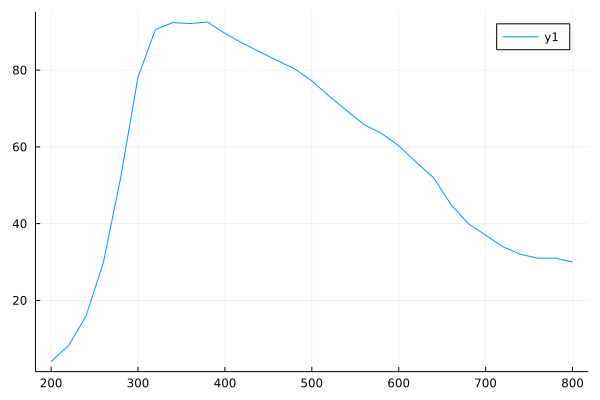

In [60]:
plot(df[!, "Wavelength(µm)"], df[!, "Transmission(%)"])

	dftof(wl, df::DataFrame, cname::String,
			   bkgnd::Float64=0.0)

Return an interpolated function, valid in range wl.

### Arguments
- `wl`::interpolation range.
- `df::DataFrame`: data frame holding the data.
- `cname::String`: name of the column holding data to be interplated.
- `overflow::Real`: value of the data outside interpolation range.

In [69]:
wl=200.0:20:800.0
fdf =LaserLab.dftof(wl, df, "Transmission(%)")

(::Main.LaserLab.var"#fn#1"{Interpolations.Extrapolation{Float64, 1, Interpolations.ScaledInterpolation{Float64, 1, Interpolations.BSplineInterpolation{Float64, 1, Vector{Float64}, Interpolations.BSpline{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Base.OneTo{Int64}}}, Interpolations.BSpline{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}}, Interpolations.BSpline{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}, Float64, Float64, Float64}) (generic function with 1 method)

In [70]:
@test all([fdf(df[1,"Wavelength(µm)"]) == df[1,"Transmission(%)"] for i in 1:31])

Test Passed

	qpdf(f, λmin::Real, λmax::Real)

Return the integral of f in the interval (λmin, λmax)
(Syntactic sugar for quadgk)

### Arguments
- `f::Function`: Function to be integrated.
- `λmin::Number`: lower bound of range.
- `λmax::Number`: upper bound of range.

In [76]:
total_area = LaserLab.qpdf(fdf, 200.0, 800.0)
green_area = LaserLab.qpdf(fdf, 400.0, 600.0)
red_area = LaserLab.qpdf(fdf, 600.0, 800.0)
@printf("r_g = %5.2f r_r = %5.2f, r_g/r_r = %5.2f ", green_area/total_area, red_area/total_area, green_area/red_area )

r_g =  0.43 r_r =  0.23, r_g/r_r =  1.88 

In [78]:
@test isapprox(green_area/red_area, 1.88, rtol=0.01) 

Test Passed


	ftopdf(wl, f)

Compute the PDF of function f in range wl.

### Arguments
- `wl`: Range of application.
- `f::Function`: Input function.


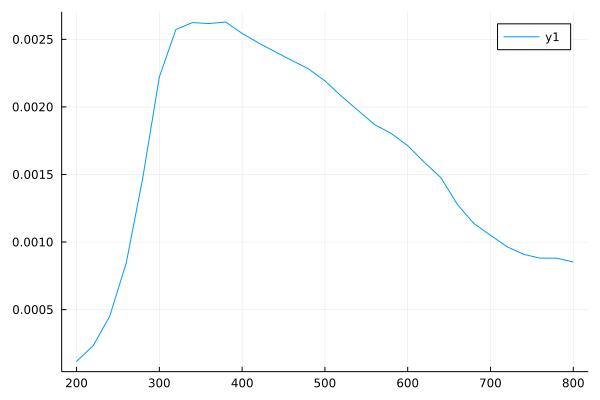

In [88]:
N, dfpdf = LaserLab.ftopdf(wl, fdf)
plot(wl, dfpdf.(wl))


In [89]:
@test total_area ≈ N 

Test Passed

# Test setup

	struct Fov

Represent a field of view

#### Fields
- `d::Unitful.Length`  : diameter of Fov
- `z::Unitful.Length`  : thickness
- `a::Unitful.Area`    : area (computed)
- `v::Unitful.Volume`  : volume (computed)


In [63]:
fov = LaserLab.Fov(1.0mm,1.0mm)

Main.LaserLab.Fov(1.0 mm, 1.0 mm, 0.7853981633974483 mm², 0.7853981633974483 mm³)

In [64]:
@test fov.a ≈ π * (fov.d/2.)^2 
@test fov.v ≈ fov.a * fov.z

Test Passed

	struct CLaser <: Laser

Simple representation of a continous laser

### Fields
- `λ::typeof(1.0nm)`  : Laser wavelength
- `P::typeof(1.0mW)`  : Power

In [172]:
luv = LaserLab.CLaser(375.0nm, 1.0μW)

Main.LaserLab.CLaser(375.0 nm, 1.0 μW)

	Objective

Simple representation of a microscope objective

#### Fields
- `name::String`       : identifies the objective
- `mode::String`       : `d` if NA and diameter specified `f` if focal and NA specified 
- `NA::Float64`        : Numerical aperture
- `M::Float64`         : Magnification
- `f::typeof(1.0mm)`   : focal distance of the lens
- `d::typeof(1.0mm)`   : diameter of the lens


In [173]:
obj = LaserLab.Objective("Specify NA & M", 0.5, 40.0)
@printf("NA = %5.1f M = %5.1f ", obj.NA, obj.M)

NA =   0.5 M =  40.0 

In [174]:
obj = LaserLab.Objective("Specify f,d & M", 5.0mm, 5.0mm, 40.0)
@printf("NA = %5.1f M = %5.1f f = %5.1f d = %5.1f", obj.NA, obj.M, obj.f/mm, obj.d/mm)

NA =   0.5 M =  40.0 f =   5.0 d =   5.0

In [175]:
dspot(λ::Real, NA::Real) = 1.83*λ/(2*NA)

dspot (generic function with 1 method)

In [147]:
dspot(360.0, 0.5) 

658.8000000000001

In [148]:
dspot(500.0, 0.5) 

915.0

In [149]:
@test LaserLab.lmu_40x_nuv_transmission(0.500μm) ==LaserLab.lmu_40x_nuv_transmission(500nm)

Test Passed

In [150]:
LaserLab.lmu_40x_nuv_transmission(500nm)

0.772

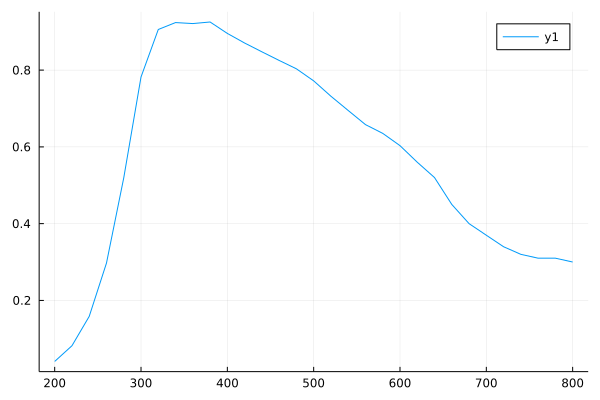

In [151]:
plot(wl, LaserLab.lmu_40x_nuv_transmission.(wl*nm))

	struct PulasedLaser

Simple representation of a pulsed laser

#### Fields
- `λ::Unitful.Length`  : Laser wavelength
- `Pk::Unitful.Power`  : peak Power
- `P::Unitful.Power`  : average power
- `f::Unitful.Frequency`  : laser frequency
- `w::Unitful.Time` : pulse width 

In [180]:
epl375 = LaserLab.PulsedLaser(375.0nm, 140.0mW, 1.0MHz, 65.0ps)

Main.LaserLab.PulsedLaser(375.0 nm, 140.0 mW, 1.0 MHz, 0.0091 mW, 65.0 ps)

	GaussianLaser

Representation of a Gaussian laser

#### Fields
- `laser::Laser`       : A laser type
- `obj::Objective`     : An objective type
- `w0::typeof(1.0nm)`  : Waist of laser at focusing point
- `zr::typeof(1.0nm)`  : z of laser at focusing point

In [204]:
luv = LaserLab.CLaser(375.0nm, 1.0μW)
epl375 = LaserLab.PulsedLaser(375.0nm, 140.0mW, 1.0MHz, 65.0ps)
lmu_40x_nuv = LaserLab.Objective("LMU-40X-NUV", 5.3mm, 5.1mm, 40.0)

Main.LaserLab.Objective("LMU-40X-NUV", 0.48113207547169806, 40.0, 5.3 mm, 5.1 mm)

In [205]:
gl  = LaserLab.GaussianLaser(epl375,lmu_40x_nuv)
@printf("λ = %5.1f nm P = %5.1f mW, w0 = %5.1f μm, I(0,0) = %5.2g mW/cm2 ρ(0,0) = %5.2g Hz/cm2", 
        uconvert(nm, gl.laser.λ)/nm, 
        uconvert(μW, gl.laser.P)/μW, 
        uconvert(nm, gl.w0)/nm, gl.I0/(mW*cm^-2), gl.ρ0/(Hz*cm^-2))

λ = 375.0 nm P =   9.1 mW, w0 = 248.1 μm, I(0,0) = 9.4e+06 mW/cm2 ρ(0,0) = 8.9e+21 Hz/cm2

In [206]:
@test gl.w0 ≈ luv.λ/(π * lmu_40x_nuv.NA)

Test Passed

In [207]:
fov = LaserLab.Fov(1.0mm,1.0mm)
luv = LaserLab.CLaser(375.0nm, 1.0μW)
obj = LaserLab.Objective("Generic", 0.5, 40.0)
obj2 = LaserLab.Objective("Generic", 5.0mm, 5.0mm, 40.0)
    
epl375 = LaserLab.PulsedLaser(375.0nm, 140.0mW, 1.0MHz, 65.0ps)
lmu_40x_nuv = LaserLab.Objective("LMU-40X-NUV", 5.3mm, 5.1mm, 40.0)
gl  = LaserLab.GaussianLaser(epl375,lmu_40x_nuv)

Main.LaserLab.GaussianLaser(Main.LaserLab.PulsedLaser(375.0 nm, 140.0 mW, 1.0 MHz, 0.0091 mW, 65.0 ps), Main.LaserLab.Objective("LMU-40X-NUV", 0.48113207547169806, 40.0, 5.3 mm, 5.1 mm), 248.09447011383688 nm, 9.41211764434409e6 mW cm⁻², 8.884068256697559e21 Hz cm⁻²)

In [187]:
function hnu_eV(lambda_nm)
    return 1240.0 * (1.0/lambda_nm)
end

hnu_eV (generic function with 1 method)

In [210]:
@test LaserLab.lmu_40x_nuv_transmission(0.500μm) ==LaserLab.lmu_40x_nuv_transmission(500nm)
@test fov.a ≈ π * (fov.d/2.)^2 
@test obj2.NA ≈ 0.5
@test fov.v ≈ fov.a * fov.z
@test gl.w0 ≈ luv.λ/(π * lmu_40x_nuv.NA)
@test isapprox(LaserLab.photon_energy(500.0nm)/eV, hnu_eV(500.0), rtol=0.01)
@test uconvert(J, LaserLab.delivered_energy(luv, 1*s)) ≈ 1.0μJ
@test LaserLab.n_photons(luv) ≈ LaserLab.n_photons(375.0nm, 1.0μW)
@test LaserLab.n_photons(luv) ≈ LaserLab.n_photons(375.0nm, 1.0μW)
@test LaserLab.n_photons_int(luv, 1.0s) ≈ LaserLab.n_photons(luv)/Hz
@test LaserLab.photon_density(375.0nm, 1.0μW, fov.a) ≈ LaserLab.photon_density(luv, fov)

Test Passed


	photon_energy(λ::Unitful.Length)

Given wavelength of photon return its energy.
#### Fields

- `λ::Unitful.Length`  : Photon wavelength


In [25]:
LaserLab.photon_energy(500.0nm)

2.4796839686640055 eV

In [27]:
function hnu_eV(lambda_nm)
    return 1240.0 * (1.0/lambda_nm)
end


hnu_eV (generic function with 1 method)

In [39]:
@test isapprox(LaserLab.photon_energy(500.0nm)/eV, hnu_eV(500.0), rtol=0.01)

Test Passed

	delivered_energy(laser::Laser, t::Unitful.Time)

Delivered energy of a laser in a given time.
#### Fields

- `laser::Laser`     : Laser
- `t::Unitful.Time`  : Time in which target is illuminated


In [43]:
uconvert(J, LaserLab.delivered_energy(luv, 1*s)) ≈ 1.0μJ

true

	n_photons(laser::Laser)

Rate of photons (number of photons per unit time) produced by a laser
#### Fields

- `laser::Laser`     : Laser
- `t::Unitful.Time`  : Time in which target is illuminated


In [45]:
LaserLab.n_photons(luv)

1.8877937128285164e12 Hz

    n_photons(λ::Unitful.Length, p::Unitful.Power)

Rate of photons (number of photons per unit time) corresponding to a wavelength
λ and a power P

#### Fields

- `λ::Unitful.Length` : photon wavelength
- `p::Unitful.Power`  : Power

In [46]:
LaserLab.n_photons(luv) ≈ LaserLab.n_photons(375.0nm, 1.0μW)

true

	n_photons_int(laser::Laser, t::Unitful.Time)

Integrated number of photons in a given time emitted by a laser

#### Fields

- `laser::Laser`    : Laser
- `t::Unitful.Time` : time of measurement

In [48]:
LaserLab.n_photons_int(luv, 1.0s) ≈ LaserLab.n_photons(luv)/Hz

true

    photon_density(λ::Unitful.Length, p::Unitful.Power, a::Unitful.Area)

number of photons per unit time per unit area

#### Fields

- `λ::Unitful.Length` : photon wavelength
- `p::Unitful.Power`  : Power
- `a::Unitful.Area`   : Area

In [50]:
LaserLab.photon_density(375.0nm, 1.0μW, fov.a)

2.4036136074756826e12 Hz mm⁻²

	photon_density(l::Laser, fov::Fov)

number of photons per unit time per unit area, in a Fov illuminated by a laser

#### Fields

- `laser::Laser` : Laser
- `fov::Fov`     : Field of view


In [51]:
LaserLab.photon_density(375.0nm, 1.0μW, fov.a) ≈ LaserLab.photon_density(luv, fov)

true


	w(gl::GaussianLaser, z::Unitful.Length)

Waist of a laser at length z

#### Fields

- `gl::GaussianLaser`  : A gaussian laser
- `z::Unitful.Length`  : z distance from focusing point


In [52]:
LaserLab.w(gl, gl.zr)

337.6186185589148 nm

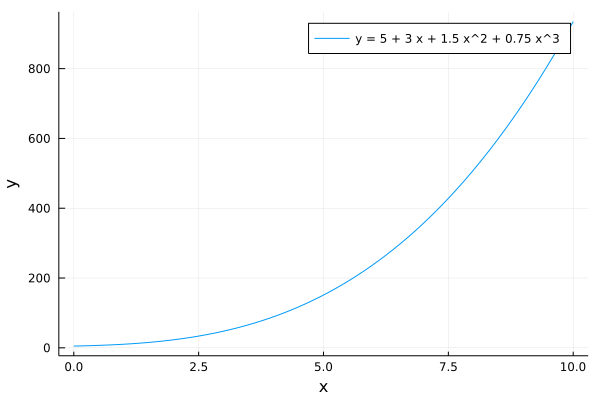

In [420]:
pol3(x, a, b, c, d) = a + b*x + c*x^2 + d*x^3
x=collect(LinRange(0., 10., 100))
y = pol3.(x,(5.0,), (3.0,), (1.5,),(0.75,),)
plot(x,y, label="y = 5 + 3 x + 1.5 x^2 + 0.75 x^3")
xlabel!("x")
ylabel!("y")  